# [Computational Social Science] Project 4: Unsupervised Learning

**Enter your Name:** John Halifax

*Semester:* Fall 2025

## Data Description and Preprocessing

For this project, you will explore data from the [National Health and Nutrition Examination Survey](https://www.kaggle.com/cdc/national-health-and-nutrition-examination-survey?select=questionnaire.csv). NHANES is a unique study that combines survey methodology with in-person medical examinations to create a dataset with demographic information, health indicators, and health outcomes.

We start by importing the data and doing some preliminary preprocessing for you. We import some libraries that will be helpful as well. 'SEQN' is the ID number for each respondent, and 'HSD010' will be our target outcome. [HSD010](https://wwwn.cdc.gov/Nchs/Nhanes/2013-2014/HSQ_H.htm#HSD010) asks for the respondent's self reported health condition, which can range from "excellent" to "poor."

In [115]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
sns.set_style("darkgrid")
from sklearn.model_selection import train_test_split

In [116]:
# Load nhanes data
nhanes = pd.read_csv('nhanes.csv')
# Get the ID numbers for each observation (seqn)
seqn = nhanes['SEQN']
# Get the target, "self-reported health condition," HSD010
hsd010 = nhanes['HSD010']
# Drop SEQN from the dataframe and then apply the standard scaler
nhanes = nhanes.drop(['SEQN', 'HSD010'], axis = 1)
nhanes_scaled = pd.DataFrame(StandardScaler().fit_transform(nhanes),
                             columns = nhanes.columns)
# Add the ID and target back in
nhanes_scaled['SEQN'] = seqn
nhanes_scaled['HSD010'] = hsd010
nhanes_scaled = nhanes_scaled.set_index('SEQN')
nhanes_scaled.head()

,DR1DRSTZ,DR1EXMER,DRABF,DRDINT,DR1DBIH,DR1DAY,DR1LANG,DR1MNRSP,DR1HELPD,DBQ095Z,...,OHQ770,OHQ845,PAAQUEX,SMQ860,SMQ870,SMQ872,SMQ874,SMQ878,SMAQUEX.x,HSD010
SEQN,,,,,,,,,,,,,,,,,,,,,
73568,0.0,2.034312,0.0,0.324834,-0.393906,1.085853,-0.194202,-0.057306,0.128246,-0.189513,...,0.383802,-0.646584,-0.484200,1.125008,0.0,-2.081666,1.087115,1.463404,0.612440,1
73576,0.0,0.261930,0.0,-3.078499,0.568251,0.634362,-0.194202,-0.057306,0.128246,0.080373,...,0.383802,-1.539259,-0.484200,1.125008,0.0,-2.081666,1.087115,-0.683338,-1.632812,1
73579,0.0,0.728346,0.0,0.324834,1.530407,-1.623092,-0.194202,-0.057306,0.128246,-0.189513,...,0.383802,-1.539259,2.065262,-0.888883,0.0,0.480384,-0.919866,-0.683338,-1.632812,2
73581,0.0,-0.857470,0.0,0.324834,0.480782,1.085853,-0.194202,-0.057306,0.128246,0.080373,...,0.383802,-0.646584,-0.484200,1.125008,0.0,0.480384,-0.919866,-0.683338,0.612440,2
73584,0.0,0.495138,0.0,0.324834,0.305844,-1.623092,-0.194202,-0.057306,0.128246,0.080373,...,-2.605509,0.246091,2.065262,1.125008,0.0,0.480384,-0.919866,1.463404,-1.632812,3


## Plots

Let's take a look at the data. Below we visualize boxplots of family income to federal poverty line ratio ('INDFMPIR') and self-reported health condition. Notice how there are some clear patterns (the lower the ratio, the lower reported health condition), but it's not a perfect separation. We have 240+ features in our dataset, and we likely have several features in our dataset that highly correlate with our family income-poverty line ratio measure - PCA will help us simplify these.

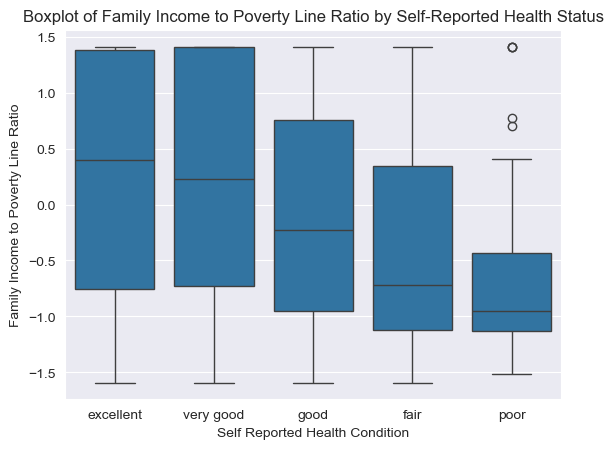

In [117]:
# Create a binary version of hsd010 where 1-3 are "good" and 4-5 are "poor"
nhanes_scaled['HSD010_binary'] = hsd010_binary = nhanes_scaled['HSD010'].replace(
    [1, 2, 3, 4, 5], ['good', 'good', 'good', 'poor', 'poor']) 
# Recode the original hsd010 with the string labels
nhanes_scaled['HSD010'] = nhanes_scaled['HSD010'].replace(
    [1, 2, 3, 4, 5], ['excellent', 'very good', 'good', 'fair', 'poor'])
# Boxplot of hsd010
ax = sns.boxplot(x = 'HSD010', y = 'INDFMPIR', data = nhanes_scaled)
ax.set(xlabel = "Self Reported Health Condition",
      ylabel = "Family Income to Poverty Line Ratio")
ax.set_title("Boxplot of Family Income to Poverty Line Ratio by Self-Reported Health Status")
plt.show()

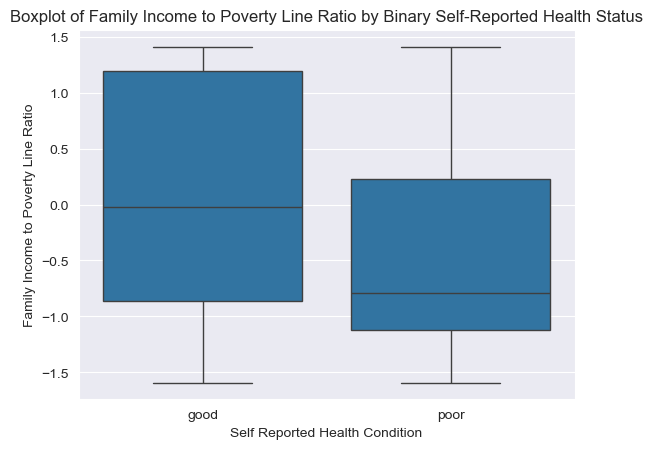

In [118]:
# Boxplot of hsd010_binary
ax = sns.boxplot(x = 'HSD010_binary', y = 'INDFMPIR', data = nhanes_scaled)
ax.set(xlabel = "Self Reported Health Condition",
      ylabel = "Family Income to Poverty Line Ratio")
ax.set_title("Boxplot of Family Income to Poverty Line Ratio by Binary Self-Reported Health Status")
plt.show()

Family income also is not necessarily well correlated with measured health outcomes. See below where we look at the relationship between Body Mass Index (BMI) and the family income-poverty line ratio, and shade points by self-reported health condition. It's hard to find a clear pattern - this is where clustering may come in handy. 

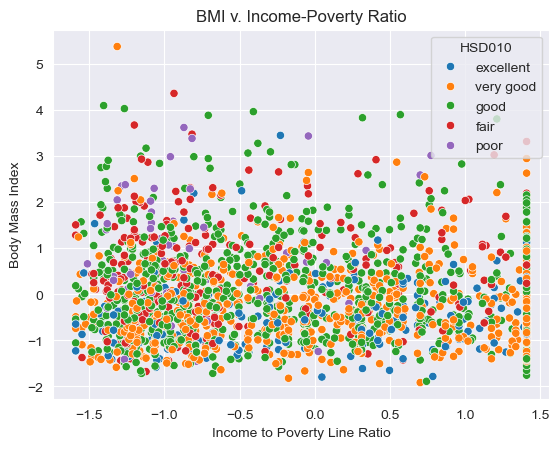

In [119]:
ax = sns.scatterplot(x = "INDFMPIR", y = "BMXBMI", hue = "HSD010", palette = "tab10", data = nhanes_scaled)
ax.set(xlabel = "Income to Poverty Line Ratio",
      ylabel = "Body Mass Index")
ax.set_title("BMI v. Income-Poverty Ratio")
plt.show()

Before we move to working on unsupervised methods, we'll drop our target variables again:

In [120]:
nhanes_scaled_labeled = nhanes_scaled
nhanes_scaled = nhanes_scaled.drop(['HSD010', 'HSD010_binary'], axis = 1)
nhanes_scaled.shape[1]

241

## Principal Component Analysis

Conduct a Principal Component Analysis (PCA) of the nhanes data. The data has already been prepared for you, so you can work directly on nhanes_scaled. Be sure to do the following:

- Choose the number of components and provide 1-2 sentences about your choice of the number of components. 
- Plot a barplot of the variation explained by each component. *Hint*: look at the attributes associated with your model. 
- Choose how many components you will use to fit a supervised learning model and provide 1-2 sentences to explain that choice.
- Plot a 2D scatterplot of the first two components and provide 1-2 sentences analyzing the plot.

### Train PCA and Discuss Number of Components

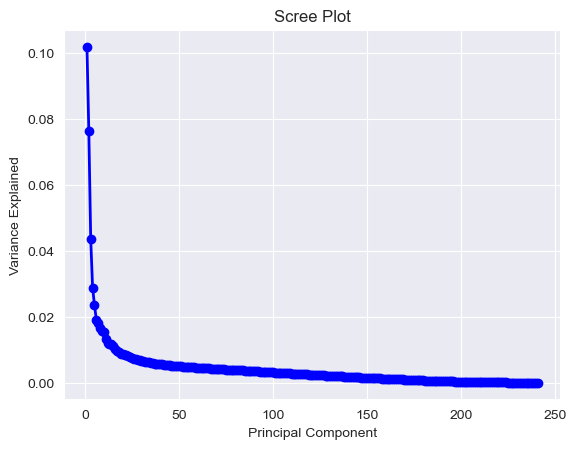

In [121]:
## Your Answer Here
pca=PCA(n_components=nhanes.shape[1])
PCA_nhanes_all=pca.fit(nhanes_scaled)
PCA_values = np.arange(PCA_nhanes_all.n_components_) + 1
plt.plot(PCA_values, PCA_nhanes_all.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

In [122]:
cum_var_explained=np.cumsum(PCA_nhanes_all.explained_variance_ratio_)
n_comp_95_perc=np.where(cum_var_explained>=0.95)[0][0]+1
n_comp_95_perc

145

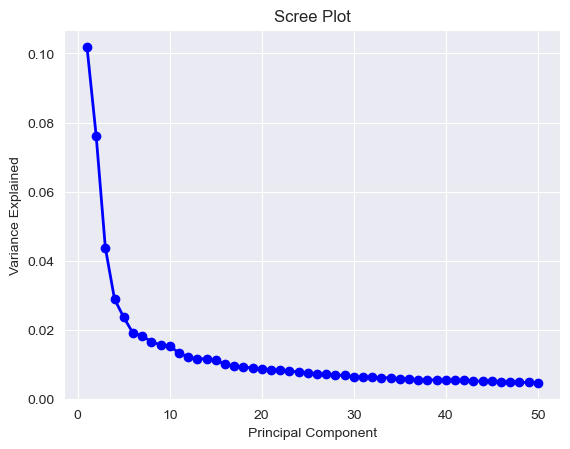

In [123]:
pca_limited=PCA(n_components=50)
PCA_nhanes_limited=pca_limited.fit(nhanes_scaled)
PCA_limited_values = np.arange(PCA_nhanes_limited.n_components_) + 1
plt.plot(PCA_limited_values, PCA_nhanes_limited.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

In [124]:
cum_var_explained_limited=np.cumsum(PCA_nhanes_all.explained_variance_ratio_)[20-1]
cum_var_explained_limited

0.46479099035773075

I chose to fit the PCA with all possible components (the number of predictors in the datatset). I did this because I wantd to look at the Scree plot across all components, and be able to assess how many components it takes me to explain a certain percetnage of the total variance.  I end up picking the 145 first principal components, as it takes this many to capture 95% of the variance in the data. This does reduce the dimensions of the data down somewhat, as we start off with 241 predictors which can be reduced by 96 without losing too much information in the data. While I would like to be able to reduce the dimensions down much more, choices of the number of components to keep near the elbow of the scree plot do not explain much of the total variance in the data (for example, the first 20 components only capture 46.5% of the total variance). While adding each individual component beyond the elbow does not add much variance alone, together the first 145 capture 95% of the total variance explained. 

In [125]:
pca_final=PCA(n_components=145)
PCA_final=pca_final.fit(nhanes_scaled)

### Barplot of Components

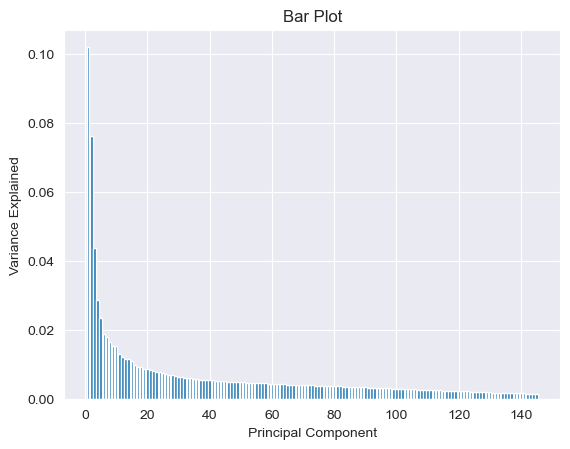

In [126]:
## Your Answer Here
PCA_final_values = np.arange(PCA_final.n_components_) + 1
plt.bar(PCA_final_values, PCA_final.explained_variance_ratio_)
plt.title('Bar Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

### How many components will you use to fit a supervised learning model?

I end up picking the 145 first principal components, as it takes this many to capture 95% of the variance in the data. This does reduce the dimensions of the data down somewhat, as we start off with 241 predictors which can be reduced by 96 without losing too much information in the data. While I would like to be able to reduce the dimensions down much more, choices of the number of components to keep near the elbow of the scree plot do not explain much of the total variance in the data (for example, the first 20 components only capture 46.5% of the total variance). While adding each individual component beyond the elbow does not add much variance alone, together the first 145 capture 95% of the total variance explained. 

### 2D Scatterplot of the first two components

In [127]:
## Your Answer Here
pca_2=PCA(n_components=2)
PCA_2_comp=pca_2.fit(nhanes_scaled)
pca_df=pd.DataFrame(data=pca_2.fit_transform(nhanes_scaled),columns = ['principal component 1', 
                                 'principal component 2'])
plot_df = pca_df.copy()
plot_df['Category5'] = nhanes_scaled_labeled['HSD010'].values
plot_df['Category2'] = nhanes_scaled_labeled['HSD010_binary'].values

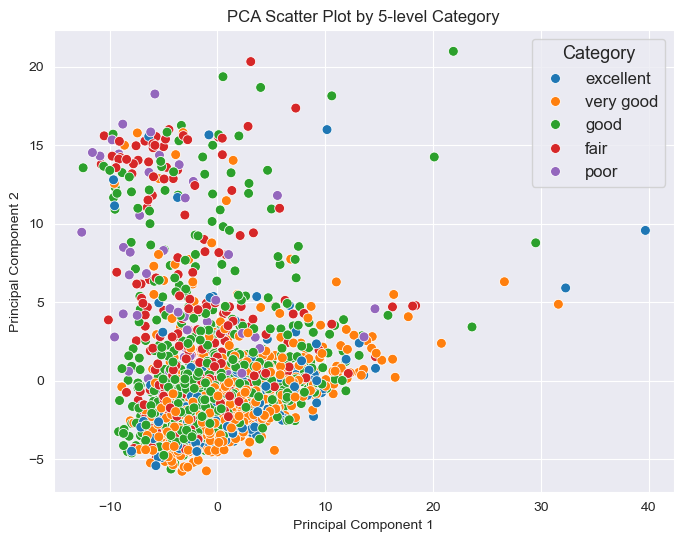

In [128]:
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=plot_df,
    x='principal component 1',
    y='principal component 2',
    hue='Category5',
    palette='tab10',   # or 'Set2', 'Paired', etc.
    s=50
)

plt.legend(title='Category', fontsize=12, title_fontsize=13)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Scatter Plot by 5-level Category')
plt.show()

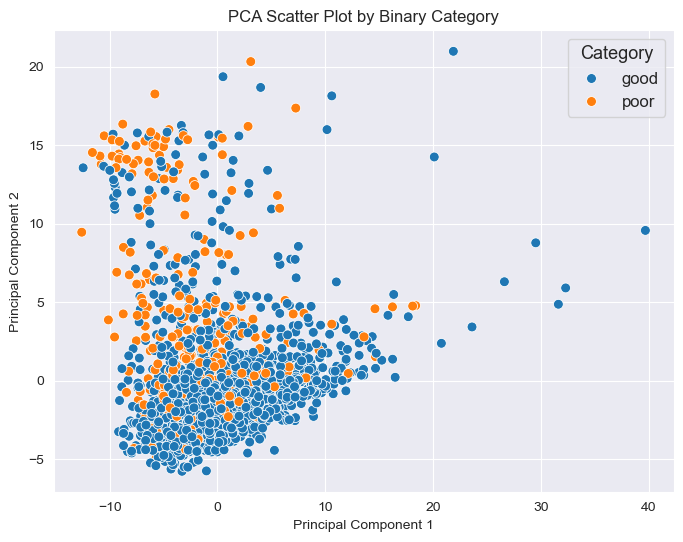

In [129]:
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=plot_df,
    x='principal component 1',
    y='principal component 2',
    hue='Category2',
    palette='tab10',   # or 'Set2', 'Paired', etc.
    s=50
)

plt.legend(title='Category', fontsize=12, title_fontsize=13)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Scatter Plot by Binary Category')
plt.show()

## K-Means

- Choose a clustering algorithm and explain it in 1-2 sentences.
- Cluster the nhanes data. Detail any choice you need to make with regards to number of clusters, and how you arrived at that choice. For instance, you might use the [elbow method](https://en.wikipedia.org/wiki/Elbow_method_(clustering)) if you choose k-means.
- Plot your clusters on top of BMI v. Income Poverty Ratio Plot. Describe what you see in 1-2 sentences.
- Retrain the clustering algorithm, but this time use your PCA results instead of the original dataframe. Plot the clusters on top of the 2D PCA scatterplot from the previous step. Describe your results in 1-2 sentences.

### Choose a Clustering Algorithm

## Your Answer Here
I choose k-means clustering (in part because it is the title of this section). K-means, unlike DBscan, requires the number of clusters *k* to be pre-specified. The algorithm begins by randomly assigning data points to *k* clusters, and the centroid (spatial mean) is calculated for each cluster. Each data point is then assigned to the cluster with the centroid it is nearest to, and the new centroids are recalculated. These two steps are repeated until data points are stably assigned to each cluster (no data point is moved to a new cluster after centroids are recalculated), or until the within cluster sum of squares stabilizes. Variations of K-means include changing the method to calculate the distance between points and using a different measure of center (e.g. a medoid) for the clusters. Determining the "best" value for *k* can be done by repeating the procedure for multiple values of *k* and comparing silhouette scores or finding the best inflection point in inertia. 

### Cluster nhanes

In [130]:
## Your Answer Here
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
k_vals=range(2,11)
silhouette_scores=[]
for k in k_vals:
    kmeans = KMeans(n_clusters=k,
                    n_init=10,
                    max_iter=300,
                    random_state=101
                    ).fit_predict(nhanes_scaled)
    score=silhouette_score(nhanes_scaled,kmeans)
    silhouette_scores.append(score)

best_k=np.array(k_vals)[(silhouette_scores==np.max(silhouette_scores))][0]
print(best_k)

2


In [131]:
kmeans = KMeans(n_clusters=best_k,
                    n_init=10,
                    max_iter=300,
                    random_state=101
                    ).fit(nhanes_scaled)
cluster_labels=kmeans.labels_
nhanes_scaled_labeled['cluster_labels']=cluster_labels

I tried values of *k* from 2 to 11 and chose the value (2) that had the maximum silhouette score. 

### Plot your clusters on top of the BMI v. Income Poverty Ratio Plot

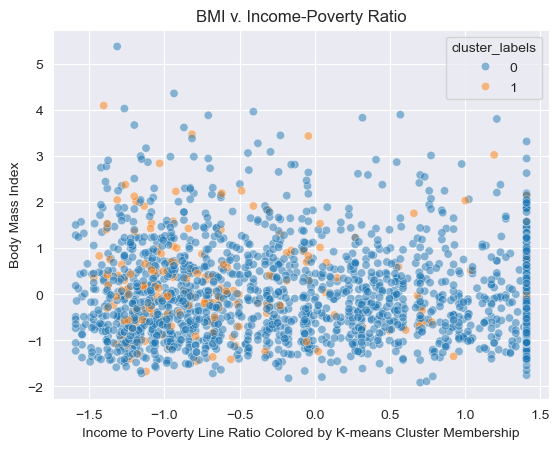

In [132]:
ax = sns.scatterplot(x = "INDFMPIR", y = "BMXBMI", hue = 'cluster_labels', palette = "tab10", alpha=0.5,
                     data = nhanes_scaled_labeled)
ax.set(xlabel = "Income to Poverty Line Ratio Colored by K-means Cluster Membership",
      ylabel = "Body Mass Index")
ax.set_title("BMI v. Income-Poverty Ratio")
plt.show()

Visually in a 2-D space defined by the two variables used above, we struggle to see any separation of the two clusters. This is likely because the cluster membership was dependent on many other variables not used in this visualization. 

### Retrain the clustering algorithm on PCA components and plot clusters on your 2D scatter

In [133]:
PCA_final_df=pd.DataFrame(pca_final.fit_transform(nhanes_scaled))
prefix="PC_"
col_names=[f"{prefix}{i}" for i in range(1,pca_final.n_components+1)] 
PCA_final_df.columns=col_names

In [134]:
k_vals=range(2,11)
pca_silhouette_scores=[]
for k in k_vals:
    kmeans = KMeans(n_clusters=k,
                    n_init=10,
                    max_iter=300,
                    random_state=101
                    ).fit_predict(PCA_final_df)
    score=silhouette_score(PCA_final_df,kmeans)
    pca_silhouette_scores.append(score)

best_k=np.array(k_vals)[(pca_silhouette_scores==np.max(pca_silhouette_scores))][0]
print(best_k)

2


In [135]:
pca_kmeans = KMeans(n_clusters=best_k,
                    n_init=10,
                    max_iter=300,
                    random_state=101
                    ).fit(PCA_final_df)
pca_cluster_labels=pca_kmeans.labels_
PCA_final_df['pca_cluster_labels']=pca_cluster_labels

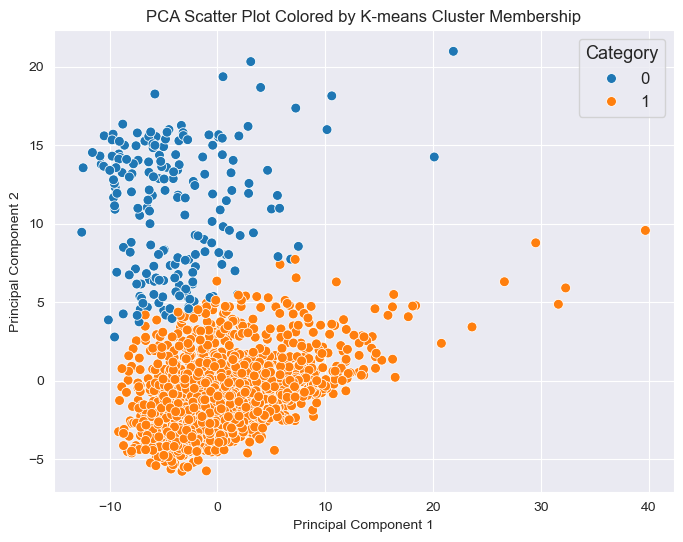

In [136]:
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=PCA_final_df,
    x='PC_1',
    y='PC_2',
    hue='pca_cluster_labels',
    palette='tab10',   # or 'Set2', 'Paired', etc.
    s=50
)

plt.legend(title='Category', fontsize=12, title_fontsize=13)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Scatter Plot Colored by K-means Cluster Membership')
plt.show()

In [137]:
print(silhouette_scores)
print(pca_silhouette_scores)

[0.23039328085803387, 0.08455413891673565, 0.03822653117476866, 0.022762848749424594, 0.022362861079918583, 0.019025922468070708, 0.013321825675128643, 0.02398640685821486, 0.005896521218155308]
[0.23126167631995306, 0.0887963627545313, 0.042076902121714235, 0.02450927377351372, 0.02238377089295739, 0.026821766277286024, 0.018351166661104517, 0.016956263757241, 0.013505357676736503]


The clustering on the principal components produces a much cleaner separation of the two clusters than when they were colored by their binary health report labels. This makes sense, as we have essentially relabeled the data by assigning clusters that are optimized to minimize within cluster distance between all the principal components. 

## Neural Network

Now we are ready to predict! Do the following:

- Choose either HSD010 or HSD010\_binary as your target outcome.  
- Train a neural network using the original features. Much of the code to train a basic neural net has been set up for you, but you will need to fill in a couple of missing pieces.
- Train a neural network using only your PCA components as features.
- Train a neural network using your PCA components and the predicted class membership from your clustering algorithm as features.
- Compare and contrast how well each algorithm did. Which featurization technique would you pick and why?

Below we provide a template for training a neural network. Use this template for training on the original features, on the PCA components, and the PCA components + the predicted classes from your clusters.

### Neural Network on Original Features

In [138]:
# partition data
# -----------
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()

y = nhanes_scaled_labeled['HSD010_binary']
print(y)
y=le.fit_transform(y)
print(le.classes_)
print(y)
#note to self, 0 is good, 1 is poor health
X = nhanes_scaled_labeled.drop(['HSD010', 'HSD010_binary', 'cluster_labels'],axis=1) # drop out any columns that aren't features

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = .25, 
                                                    random_state = 10)

SEQN
73568    good
73576    good
73579    good
73581    good
73584    good
         ... 
83694    good
83696    good
83704    poor
83716    good
83721    good
Name: HSD010_binary, Length: 2064, dtype: object
['good' 'poor']
[0 0 0 ... 1 0 0]


In [139]:
# load libraries
# -----------
import keras
import random
import tensorflow as tf
from keras.utils import to_categorical


In [140]:
# create neural network model
# -----------
from keras.layers import Dropout
from keras.layers import BatchNormalization

SEED=101
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
model = Sequential()

model.add(Dense(100, input_dim= X_train.shape[1], kernel_initializer= "he_normal", activation= "relu"))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(50, kernel_initializer= "he_normal", activation= "relu"))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(1, kernel_initializer= "he_normal", activation= "sigmoid"))

model.compile(loss= "binary_crossentropy", optimizer= "adam", metrics=['accuracy'])

nn1=model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=30, batch_size=32, verbose=0)

/Applications/anaconda3/envs/CSS/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [141]:
nn1.history['val_accuracy'][-1]

0.8643410801887512

### Neural Network on Principal Components

In [142]:
X_pca=PCA_final_df.drop(['pca_cluster_labels'],axis=1)
X_train_pca1, X_test_pca1, y_train_pca1, y_test_pca1 = train_test_split(X_pca, 
                                                    y, 
                                                    test_size = .25, 
                                                    random_state = 10)
#num_classes = 2
# convert class vectors to binary class matrices
#y_train_pca1 = keras.utils.to_categorical(y_train_pca1, num_classes)
#y_test_pca1 = keras.utils.to_categorical(y_test_pca1, num_classes)
#num_classes = y_test_pca1.shape[1]

In [143]:
SEED=100
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

model = Sequential()

model.add(Dense(100, input_dim= X_train_pca1.shape[1], kernel_initializer= "he_normal", activation= "relu"))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(50, kernel_initializer= "he_normal", activation= "relu"))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(1, kernel_initializer= "he_normal", activation= "sigmoid"))

model.compile(loss= "binary_crossentropy", optimizer= "adam", metrics=['accuracy'])

nn2=model.fit(X_train_pca1, y_train_pca1, validation_data=(X_test_pca1, y_test_pca1), epochs=30, batch_size=32, verbose=0)

/Applications/anaconda3/envs/CSS/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [144]:
nn2.history['val_accuracy'][-1]

0.8662790656089783

### Neural Network on Principal Components + Cluster Membership

In [145]:
print(PCA_final_df.columns)
X_pca=PCA_final_df
X_train_pca2, X_test_pca2, y_train_pca2, y_test_pca2 = train_test_split(X_pca, 
                                                    y, 
                                                    test_size = .25, 
                                                    random_state = 10)


Index(['PC_1', 'PC_2', 'PC_3', 'PC_4', 'PC_5', 'PC_6', 'PC_7', 'PC_8', 'PC_9',
       'PC_10',
       ...
       'PC_137', 'PC_138', 'PC_139', 'PC_140', 'PC_141', 'PC_142', 'PC_143',
       'PC_144', 'PC_145', 'pca_cluster_labels'],
      dtype='object', length=146)


In [146]:
SEED=100
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

model = Sequential()

model.add(Dense(100, input_dim= X_train_pca2.shape[1], kernel_initializer= "he_normal", activation= "relu"))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(50, kernel_initializer= "he_normal", activation= "relu"))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(1, kernel_initializer= "he_normal", activation= "sigmoid"))

model.compile(loss= "binary_crossentropy", optimizer= "adam", metrics=['accuracy'])

nn3=model.fit(X_train_pca2, y_train_pca2, validation_data=(X_test_pca2, y_test_pca2), epochs=30, batch_size=32, verbose=0)

/Applications/anaconda3/envs/CSS/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [147]:
nn3.history['val_accuracy'][-1]

0.8662790656089783

I chose to use the binary outcome variable as my target. Originally I found, without much informed tinkering of the Keras models, that the PCA predictors mildly improved the accuracy of my 2-category classifier from 0.864 to 0.866, while using a combination of principal components and clustering labels as features drastically matched this accuracy of 0.864. However, on rerunning my notebook and doing my best to set seeds for all possible sources of randomness, I seem to get slightly different answers. As I type this, I actaully find that my original set of predictors does better (accuracy = 0.864) than the PCA or PCA+cluster labels (both have accuracies of 0.860). 

Despite the lack of obvious empirical evidence from this homework exercise, I would be tempted to use the PCA and cluster label feature set as it provides the possibility to give the model patterns in the data that the model itself may not capture otherwise. I would also be tempted to try a feature set that includes principal components, cluster labels from multiple rounds of clustering with different algorithms and cluster hyperparameters (e.g. *k*), and the original set of features. 

## Discussion Questions

1. In your own words, what is the difference between PCA and clustering?

PCA 

2. Did you notice any advantages to combining PCA and clustering? If so, what do you think they were? If not, why do you think you didn't see any gains from this combination?

Unfortunately, I did not see any clear gains from combining PCA and clustering as a set of features for prediction. My calculated test set accuracy for my 3 neural nets (while changing slightly each time I run my notebook) are all about that same (approximately 0.86), but the neural nets trained on only principal components or principal components and cluster labels did so with fewer features. I did find advantages in using PCA and clustering to explore patterns in my data. For example, after trying several values of *k*, I found that a value of 2 was best, which helped inform my choice for which version of the outcome variable to use in my neural net work. Additionally, PCA allowed me to visualize patterns in my high-dimensional data quite easily, whereas using key predictors such as BMI did not provide as much insight. 

I hypothesize that I did not see a large gain in prediction accuracy when using principal components and cluster labels as features instead of the original covariates is because it took quite a lot of principal components (145 of 241 possible) to capture 95% of the total variance. There was limited gain in variance captured in the later principal components, but the first 20 or so captured less than 50% of the total variance. In other words, perhaps the principal components I used did not summarize the data all that well, and therefore did not facilitate improved model performance. The lack of gain from including the cluster labels could be due to the two clusters used not aligning well with the binary outcome (i.e. there are two outcome groups, and two clusters, but these do not capture the same phenomenon). I could have possible improved the effectiveness of the cluster labesl as predictors by including multiple version of cluster labels as predictors (e.g. multiple k-means with different *k* values, other cluster labels from other clustering algorithms). 

3. How can unsupervised techniques help with downstream supervised learning tasks when working with "big data?"

Unsupervised techniques work quite well as feature engineering approaches, where the original set of covariates or predictors are manipulated to provide more predictive signal. Using PCA or clustering approaches in the context of "big data" can be useful to capture information or patterns in the original, full dataset, but with many fewer predictors. This dimension reduction can improve computational overhead, avoid the curse of dimensionality, and possibly improve prediction performance. They can both also be used for exploratory data analysis, as they both facilitate visualizations of "big data" where information from all or multiple covariates can be summarized into limited dimensions that humans can easily visualize. 